In [1]:
import pandas as pd
import numpy as np
import baltic as bt
from scipy import stats
from random import choice
from collections import defaultdict
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style='whitegrid', font_scale=1.5, palette='Paired')

In [2]:
######  CONFIG; EDIT ME  #####
date_range = (1970., 2015.) # informative date range
years_forward = 5 # how many years in the future to predict

# actual frequencies
frequency_path = '../../data/titer-model/frequencies/southeast_asia_clade_frequencies.csv'

# canonical genotype MRCAs
genotype_clades = [str(i) for i in [2185,2589,2238,2596,1460,1393,1587,1455,975,979,1089,33,497,117,543,4,638] ] 

##### Input and setup #####
all_frequencies = pd.read_csv(frequency_path, index_col=0)[genotype_clades] # pd.DataFrame(columns=clades, index=timepoints, values=relative frequencies)
all_frequencies = all_frequencies.loc[(all_frequencies.index >= date_range[0]) & (all_frequencies.index <= date_range[1])] # only look at reliable date range

timepoints = all_frequencies.index.tolist() # all pivots
n_years = int(timepoints[-1]) - int(timepoints[0]) # number of years in the frequencies dataset
tppy = int(len(timepoints)/n_years) # timepoints per year

tp_forward = years_forward*tppy # number of timepoints forward to predict

In [3]:
def normalize_frequencies_by_timepoint(frequencies):
    ''' Normalize each row so that the sum of all frequencies at a single timepoint = 1'''
    def normalize(row):
        total = row.sum()
        if np.isnan(total) or total == 0:
            return row
        else:
            return row.map( lambda x: x / total)
    
    if isinstance(frequencies, dict):
        frequencies = pd.DataFrame(frequencies)
        normalized_frequencies = frequencies.apply(normalize, axis=1)
        return normalized_frequencies.to_dict()

    else:
        normalized_frequencies = frequencies.apply(normalize, axis=1)
        return normalized_frequencies

all_frequencies = normalize_frequencies_by_timepoint(all_frequencies) # normalize the actual frequencies

In [4]:
fit_vals = np.linspace(-1., 1.) 
delta_fit_vals = np.linspace(-0.1, 0.1)
fitness = defaultdict(dict)

for clade in genotype_clades:
    final_fitnesses = [choice(fit_vals)] # initialize each clade's fitness as a random float between [-1., 1)
    for idx in range(1,len(timepoints)):
        final_fitnesses.append(final_fitnesses[idx-1]+choice(delta_fit_vals)) # at each timepoint, fitness changes randomly by a value of [-.1, .1)
    fitness[clade] = final_fitnesses

fitness = pd.DataFrame(fitness, index=timepoints)
null_fitness = pd.DataFrame(index=timepoints, columns=genotype_clades)
null_fitness.fillna(0., inplace=True)
print 'Random fitness'
print fitness.head()
print 'Null fitness'
print null_fitness.head()

Random fitness
             1089       117      1393      1455      1460      1587      2185  \
1970.00  0.632653 -0.387755  0.714286 -0.428571 -0.836735  0.346939 -0.224490   
1970.25  0.667347 -0.308163  0.712245 -0.361224 -0.859184  0.369388 -0.169388   
1970.50  0.595918 -0.338776  0.681633 -0.355102 -0.812245  0.318367 -0.151020   
1970.75  0.532653 -0.324490  0.589796 -0.344898 -0.863265  0.267347 -0.148980   
1971.00  0.624490 -0.375510  0.575510 -0.318367 -0.861224  0.212245 -0.163265   

             2238      2589          2596        33         4       497  \
1970.00 -0.469388 -0.102041  1.428571e-01  1.000000  0.102041 -0.632653   
1970.25 -0.528571 -0.006122  6.734694e-02  1.063265  0.010204 -0.553061   
1970.50 -0.612245  0.028571 -6.938894e-17  1.061224 -0.057143 -0.587755   
1970.75 -0.667347 -0.063265  5.102041e-02  1.095918 -0.095918 -0.524490   
1971.00 -0.763265 -0.008163  1.469388e-01  1.008163 -0.155102 -0.481633   

              543       638       975       979

In [5]:
 ##### Predict frequencies #####
    
def predict_timepoint(initial_frequency, initial_fitness, years_forward):
    if initial_frequency < 0.15:
        return np.nan
    else:
        return initial_frequency*np.exp(initial_fitness*years_forward)
    

In [6]:
def rolling_prediction(i, fitness=fitness, all_frequencies=all_frequencies, 
                           timepoints=timepoints, tp_forward=tp_forward, 
                           years_forward=years_forward):
    '''
    For each timepoint t, predict the frequency of i based on 
    its fitness and initial frequency at time t-years_forward
    '''
    
    initial_fitnesses = fitness[i]
    initial_frequencies = all_frequencies[i]
    initial_timepoints = timepoints[: -1*tp_forward]

    predicted_frequencies = { t+years_forward : predict_timepoint(initial_frequencies[t], 
                                                                  initial_fitnesses[t], 
                                                                  years_forward)
                            for t in initial_timepoints}
    return predicted_frequencies


def normalize_rolling_prediction(cocirculating_clades=genotype_clades, fitness=fitness,
                                 frequencies=all_frequencies,
                                 timepoints=timepoints, tp_forward=tp_forward, 
                                 years_forward=years_forward):
    '''
    Making a rolling prediction of frequency for each clade.
    Normalize these predicted frequencies so that they sum to 1. at each timepoint
    '''
    
    all_predicted_frequencies = { i : rolling_prediction(i, fitness, frequencies,
                                                             timepoints, tp_forward, 
                                                             years_forward)
                                for i in cocirculating_clades }
    
    normalized_predicted_frequencies = normalize_frequencies_by_timepoint(all_predicted_frequencies)
    return normalized_predicted_frequencies

In [7]:
null_rolling_predictions = normalize_rolling_prediction(fitness=null_fitness)
random_rolling_predictions = normalize_rolling_prediction(fitness=fitness)

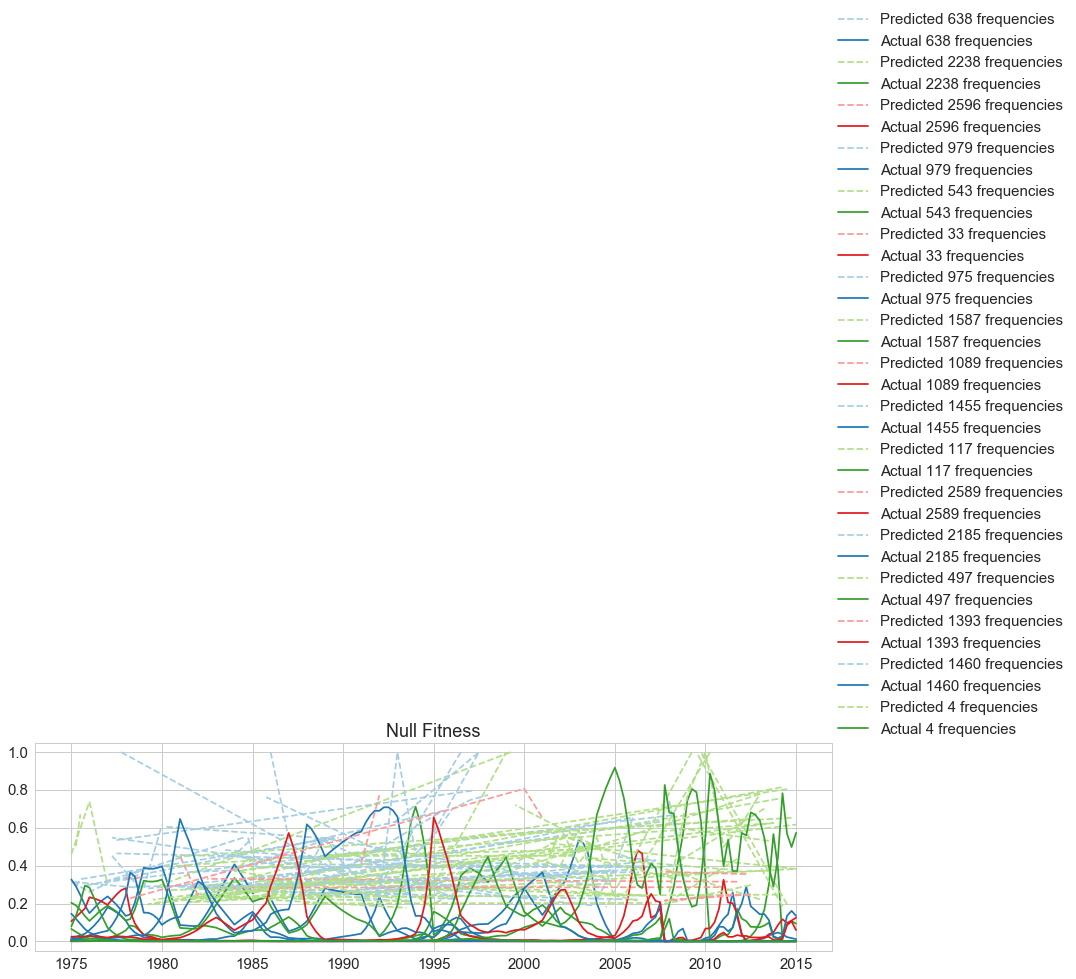

/Users/Sidney/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater


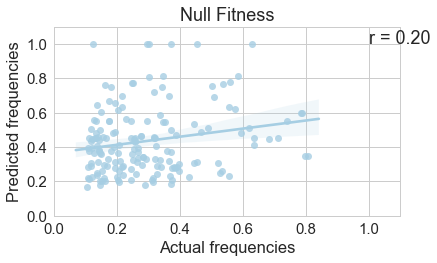

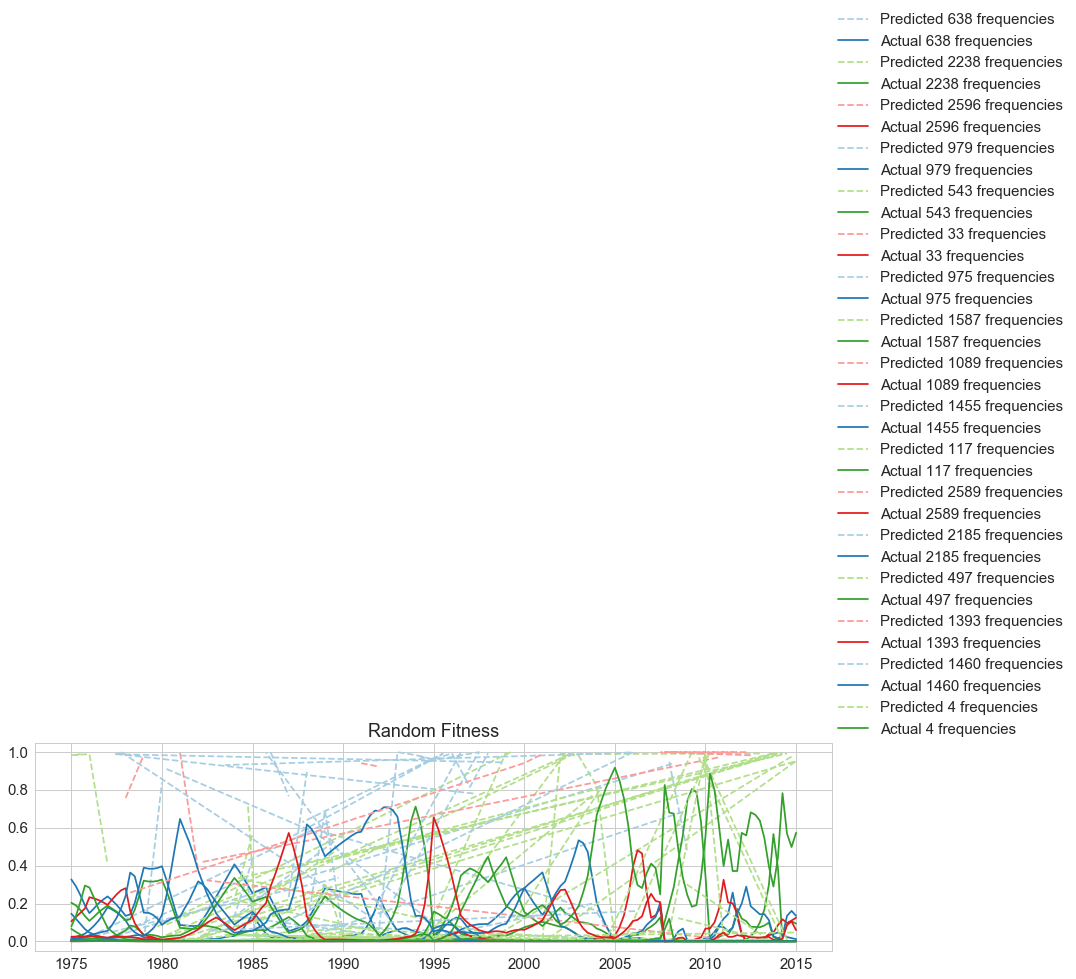

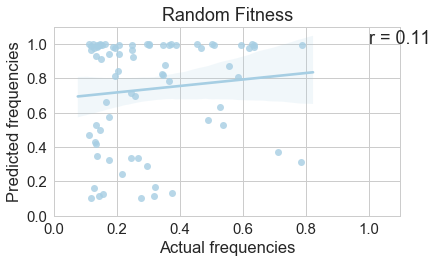

In [8]:
def test_rolling_predictions(predicted_frequencies, actual_frequencies, title=None):
       
    '''
    For the actual and predicted frequencies, find where both values are non-null and > 0.1
    Plot actual vs. predicted
    '''
        
    predicted_clades = predicted_frequencies.keys()
    predicted_date_range = (min(predicted_frequencies[predicted_clades[0]].keys()), 
                            max(predicted_frequencies[predicted_clades[0]].keys()))
    
    actual = []
    predicted = []
                            
    for clade, predicted_freqs in predicted_frequencies.items():
        actual += actual_frequencies[clade][predicted_date_range[0]:predicted_date_range[1]].tolist()
        predicted += predicted_freqs.values()
          
    actual = np.array(actual)
    predicted = np.array(predicted)
    mask = (~np.isnan(actual)) & (~np.isnan(predicted)) & (actual > 0.1) & (predicted > 0.1)

    fit = stats.linregress(actual[mask], predicted[mask])

    ax=sns.regplot(actual[mask], predicted[mask])
    ax.set_xlabel('Actual frequencies')#, X(t+%d)/X(t)'%years_forward)
    ax.set_ylabel('Predicted frequencies')#, X(t+%d)/X(t)'%years_forward)
    ax.set_xlim(0,1.1)
    ax.set_ylim(0,1.1)
    ax.text(1,1,'r = %.2f'%fit[2], )
    if title:
        ax.set_title(title)
    plt.tight_layout()
    plt.show()

def plot_rolling_frequencies(predicted_frequencies, all_frequencies, title=None):    
    '''
    Plot the predicted frequency of each clade over time (predicted on a rolling basis, based on fitness at t-years_forward)
    Plot the actual frequency of each clade over time to compare.
    '''
    
    fig, ax = plt.subplots(1,1,figsize=(12,4))
    
    for clade, predicted_freqs in predicted_frequencies.items():
        predicted_date_range = (min(predicted_freqs.keys()), max(predicted_freqs.keys()))
        x,y = zip(*predicted_freqs.items())
        ax.plot(x,y, linestyle='--', label='Predicted %s frequencies'%clade)
        
        actual_frequencies = all_frequencies[clade][predicted_date_range[0] : predicted_date_range[1]]
        ax.plot(actual_frequencies.index.values, actual_frequencies.values, label='Actual %s frequencies'%clade)
        
    if title:
        ax.set_title(title)
    plt.legend(loc=(1,1))
    plt.tight_layout()
    plt.show()
    
plot_rolling_frequencies(null_rolling_predictions, all_frequencies, 'Null Fitness')
test_rolling_predictions(null_rolling_predictions, all_frequencies, 'Null Fitness')
plot_rolling_frequencies(random_rolling_predictions, all_frequencies, 'Random Fitness')
test_rolling_predictions(random_rolling_predictions, all_frequencies, title='Random Fitness')

In [9]:
def predict_trajectory(i, initial_timepoint, tppy, tp_forward, fitness_vals, initial_frequencies):
    '''
    Predict the frequency of clade i at each time interval between t and t+years_forward, 
    based on its fitness and frequency at time t
    '''
    
    
    dt_values = [ (1./tppy)*dt for dt in range(1, tp_forward+1)] # fraction of year per timepoint * number of timepoints forward
    predicted_timepoints = [ initial_timepoint + dt for dt in dt_values ]
    initial_frequency = initial_frequencies[i][initial_timepoint]
    initial_fitness = fitness_vals[i][initial_timepoint]
    
    predicted_trajectory = [ predict_timepoint(initial_frequency, initial_fitness, dt) for dt in dt_values ]
    
    return pd.Series(predicted_trajectory, index=predicted_timepoints, name=i)
    
def predict_normalize_trajectory(initial_timepoint, tppy, tp_forward, fitness_vals, cocirculating_clades=genotype_clades, initial_frequencies=all_frequencies):
    '''
    Predict the frequency of all clades at each time interval between t and t+years_forward,
    based on their initial fitnesses and frequencies at time t.
    
    Normalize these predicted frequencies so that they sum to 1. at each timepoint.
    '''
    
    
    all_trajectories = pd.DataFrame({ i : predict_trajectory(i, initial_timepoint, tppy, tp_forward, fitness_vals, initial_frequencies)
                       for i in cocirculating_clades})
    all_trajectories = normalize_frequencies_by_timepoint(all_trajectories)
    
    return all_trajectories

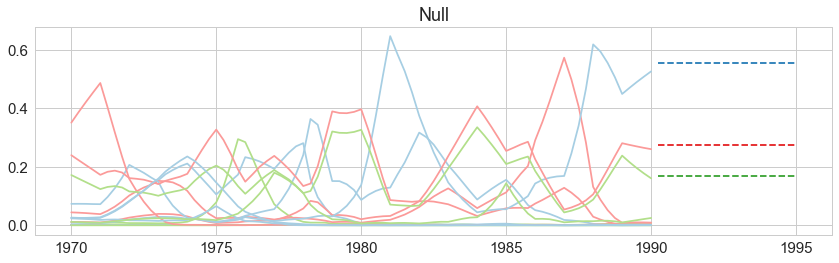

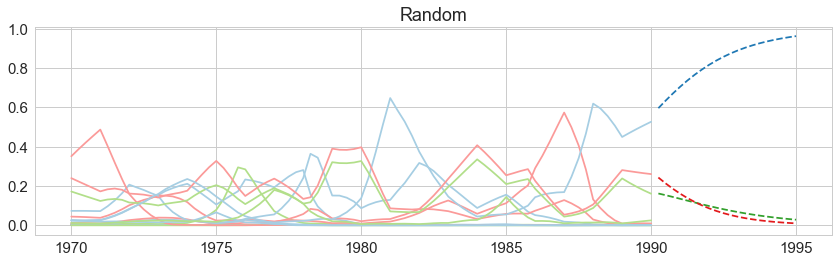

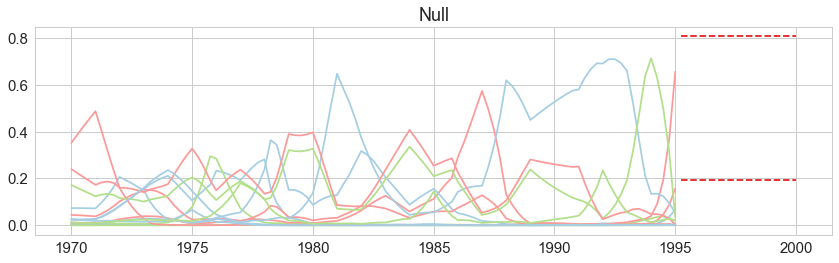

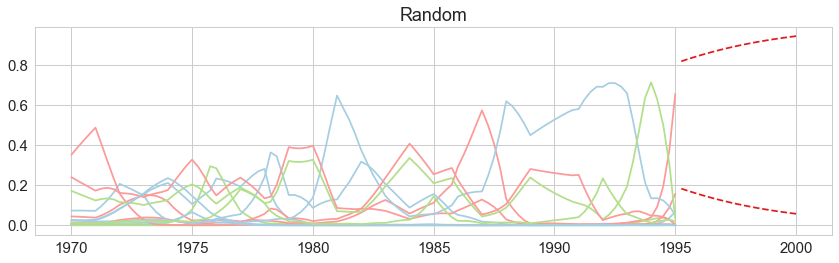

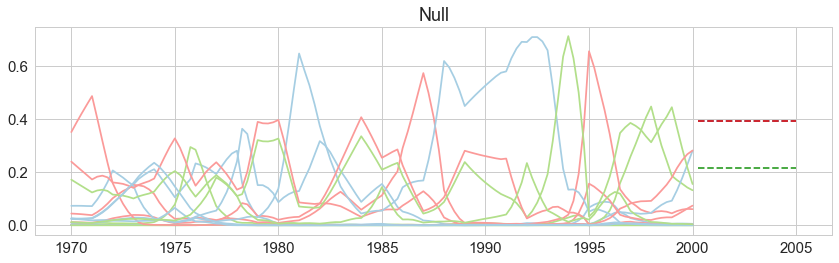

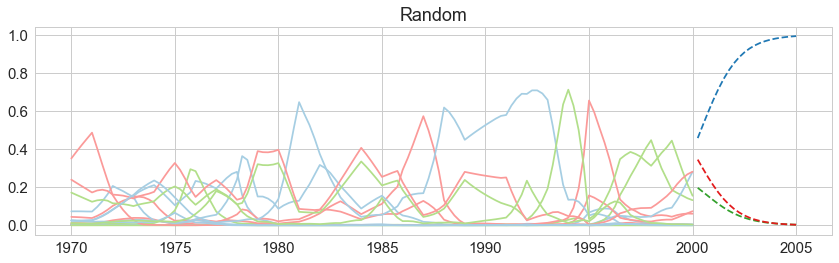

In [10]:
def plot_frequency_trajectory(initial_timepoint, fitness_vals, tppy=tppy, tp_forward=tp_forward,
                              cocirculating_clades=genotype_clades, frequencies=all_frequencies, title=None):
    sns.set_palette('Paired')
    
    fig, ax = plt.subplots(1,1,figsize=(12,4))
    
        
    predicted_trajectories = predict_normalize_trajectory(initial_timepoint, tppy, tp_forward, fitness_vals, 
                                                        cocirculating_clades=genotype_clades, 
                                                        initial_frequencies=frequencies)

    for clade, predicted_trajectory in predicted_trajectories.iteritems():
        actual_vals = frequencies[clade][:initial_timepoint]
        ax.plot(actual_vals.index.values, actual_vals.values, label='Actual %s frequencies'%clade)
        
        ax.plot(predicted_trajectory.index.values, predicted_trajectory.values, linestyle='--', label='Predicted %s frequencies'%clade)
        
    if title:
        ax.set_title(title)
    plt.tight_layout()
#     plt.legend(loc=(1,1))
    plt.show()

for y in [1990., 1995., 2000.]:
    for model, title in zip([null_fitness, fitness], ['Null', 'Random']):

        plot_frequency_trajectory(initial_timepoint=y, fitness_vals=model, title=title)